# Academic Work 2 - Dimensionality reduction
Authors:
 - Igor Czudy
 - Anna Panfil

In [135]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [136]:
df = pd.read_excel("Reflex_C.xlsx")
df.head(3)

,CASE_ID,Gender,Age,StudiesFather,StudiesMother,Field,ISCED5A,University,RegionStudies,GradePerformance,...,Work_Autonomy,Job_Stability,Opportunity_Things,High_Income,Meeting_Challenges,Good_Prospects,Have_Yourself,Acknowledgment_Acknowledgment,Opportunity_Yourself,Work_Balance
0,204283,Male,30,Primary education,Primary education,Architecture & Engineering,Master,Universitat Politècnica de València,Comunidad Valenciana,Good,...,4,5,5,5,4,5,5,2,4,5
1,201581,Female,31,Higher education,Higher education,"Business, management & Economy",Master,Universitat de València,Comunidad Valenciana,Approved,...,4,4,4,3,4,4,5,4,4,5
2,202193,Female,31,Primary education,Primary education,Social Sciences,Bachelor,Universidade da Coruña,Galicia,Approved,...,4,5,4,4,4,5,4,3,4,5


In [137]:
X = df.loc[:,"Work_Autonomy" : "Work_Balance"]
X.head()

,Work_Autonomy,Job_Stability,Opportunity_Things,High_Income,Meeting_Challenges,Good_Prospects,Have_Yourself,Acknowledgment_Acknowledgment,Opportunity_Yourself,Work_Balance
0,4,5,5,5,4,5,5,2,4,5
1,4,4,4,3,4,4,5,4,4,5
2,4,5,4,4,4,5,4,3,4,5
3,4,4,4,4,5,4,4,3,3,4
4,2,4,4,3,4,3,2,3,3,2


In [138]:
X.shape

(2117, 10)

Text(0.5, 1.0, 'Pearson corralation matrix')

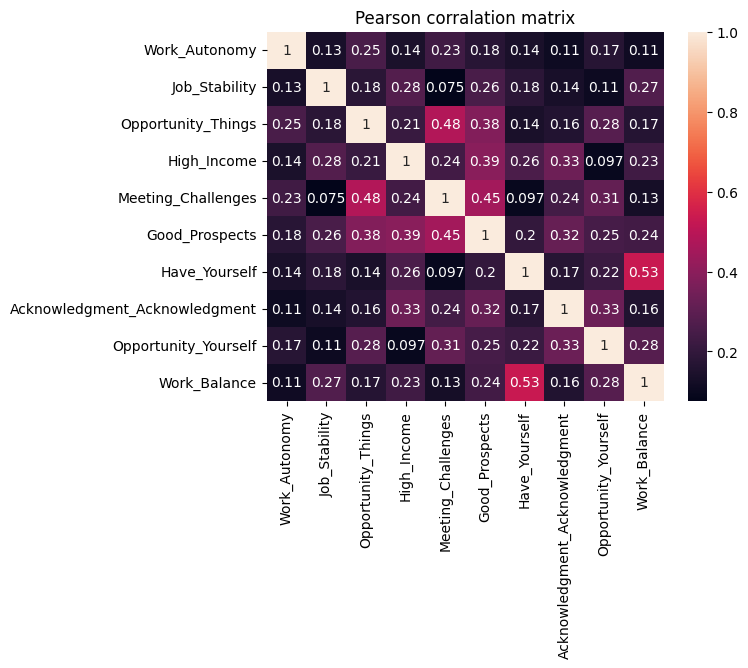

In [139]:
import seaborn as sns
sns.heatmap(X.corr(), annot=True)
plt.title("Pearson corralation matrix")

We've looked at the correlation matrix to guess which variables may have something in common. Based on correlation and names we thought about 3 groups: [Good_Prospects, Opportunity_Yourself, Meeting Challenges], [High Income, Job Stability, Work Autonomy, Acknowledgment_Acknowledgment] and  [Work Balance, Have_Yourself].

## KMO measure

In [140]:
from factor_analyzer.factor_analyzer import calculate_kmo

kmo_score, kmo_model = calculate_kmo(X)
print("KMO value:", kmo_score)

print(f"Number of KMO value bigger then 0.6: {sum(kmo_score>0.6)}, all:{len(kmo_score)}")

KMO value: [0.86340374 0.78157495 0.79461606 0.77859695 0.75426836 0.82228363
 0.69049744 0.76433367 0.76291552 0.68967904]
Number of KMO value bigger then 0.6: 10, all:10


We can conduct factor analysis. 

## Factor analysis

In [141]:
from factor_analyzer.factor_analyzer import FactorAnalyzer 
fa = FactorAnalyzer(rotation='varimax')
X_transformed = fa.fit_transform(X)

# Check Eigenvalues
ev, v = fa.get_eigenvalues()


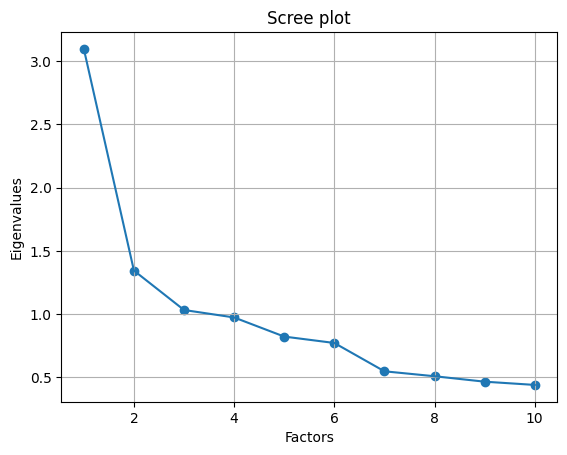

In [142]:
plt.scatter(range(1, X.shape[1]+1), ev)
plt.plot(range(1,X.shape[1]+1), ev)
plt.title("Scree plot")
plt.xlabel("Factors")
plt.ylabel("Eigenvalues")
plt.grid()

We've plotted eigenvalues of factor loading matrix too see how many fators we should choose. We can see the elbow point in 3 factors, so this is the number we'll use.

In [143]:
fa = FactorAnalyzer(rotation='varimax', n_factors=3)
X_transformed = fa.fit_transform(X)

<function matplotlib.pyplot.show(close=None, block=None)>

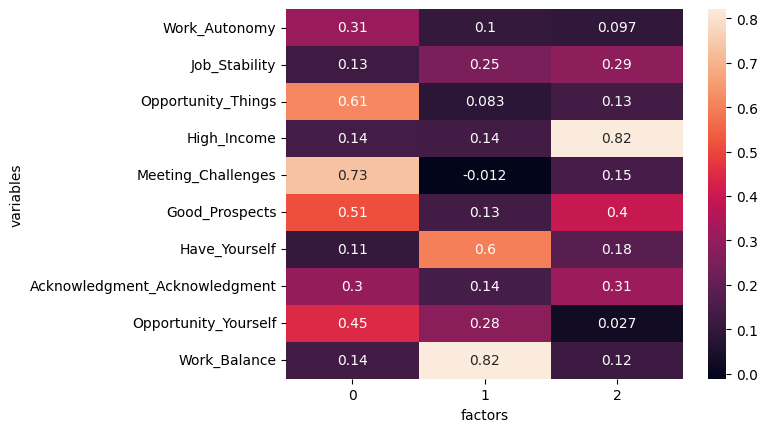

In [144]:
sns.heatmap(pd.DataFrame(fa.loadings_.T, columns=X.columns).T, annot=True)
plt.xlabel("factors")
plt.ylabel("variables")
plt.show

From the loading we can conclude that factor 0 seems to be related to **self development** at workplace (challenges, opportunities, prospects, autonomy). Factor 1 is a **time for yourself** outside of work (work balance, have_yourself, opportunities) and factor 3 represents good **economic situation** (income, stability, prospects).

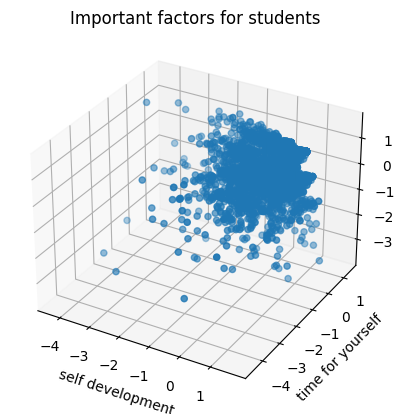

In [145]:
from mpl_toolkits.mplot3d import Axes3D

ax = plt.axes(projection='3d')

ax.scatter3D(X_transformed[:,0], X_transformed[:,1], X_transformed[:,2])
ax.set_xlabel('self development')
ax.set_ylabel('time for yourself')
ax.set_zlabel('economic situation')
ax.set_title('Important factors for students')
plt.show()

## Cluster analysis

In [146]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X = pd.DataFrame(X_scaled, columns=X.columns)

### Kmeans algorythm

In [147]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=300, n_init=10, random_state=42)
cluster_labels = kmeans.fit_predict(X)

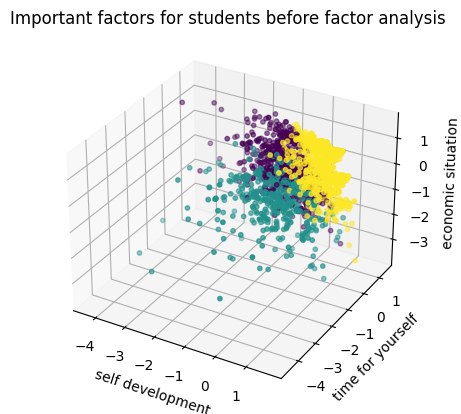

In [148]:
ax = plt.axes(projection='3d')

ax.scatter3D(X_transformed[:,0], X_transformed[:,1], X_transformed[:,2], s=10, c=cluster_labels)
ax.set_xlabel('self development')
ax.set_ylabel('time for yourself')
ax.set_zlabel('economic situation')
ax.set_title('Important factors for students before factor analysis ')

plt.show()


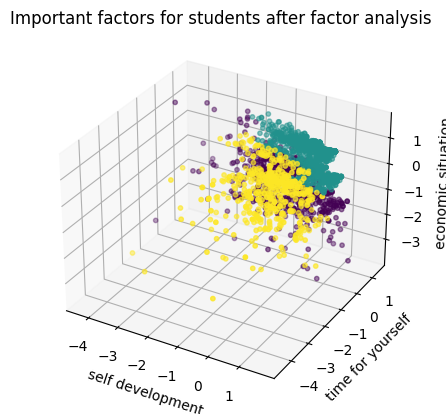

In [149]:
kmeans_transformed = KMeans(n_clusters=3, init='k-means++', max_iter=300, n_init=10, random_state=42)
cluster_labels = kmeans_transformed.fit_predict(X_transformed)

ax = plt.axes(projection='3d')

ax.scatter3D(X_transformed[:,0], X_transformed[:,1], X_transformed[:,2], s=10, c=cluster_labels)
ax.set_xlabel('self development')
ax.set_ylabel('time for yourself')
ax.set_zlabel('economic situation')
ax.set_title('Important factors for students after factor analysis ')

plt.show()

To determine which number of clusters is the best we use **Davies Bouldin** score and **Calinski Harabasz** score. 

In [150]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist, pdist
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score
dbs=[]
chs = []
for i in range(2, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(X)
    chs.append(calinski_harabasz_score(X, kmeans.labels_))
    dbs.append(davies_bouldin_score(X, kmeans.labels_))


/home/igor/.conda/envs/ml/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


/home/igor/.conda/envs/ml/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/igor/.conda/envs/ml/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/igor/.conda/envs/ml/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/igor/.conda/envs/ml/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/ig

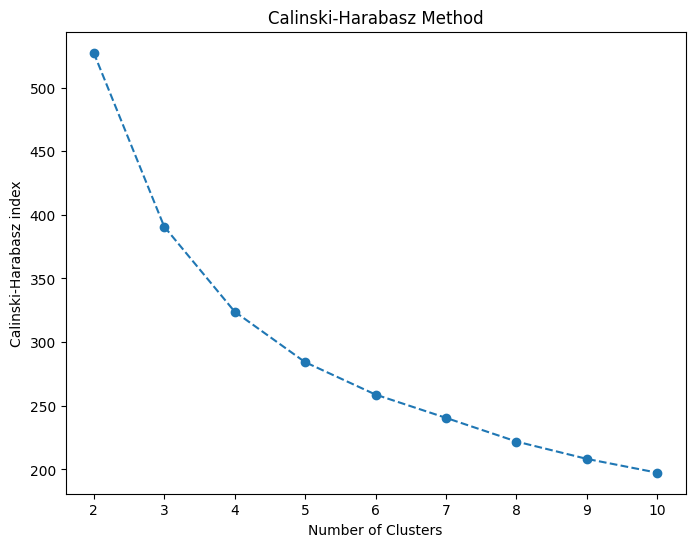

In [151]:
plt.figure(figsize=(8, 6))
plt.plot(range(2, 11), chs, marker='o', linestyle='--')
plt.title('Calinski-Harabasz Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Calinski-Harabasz index')
plt.show()

On graph above, we should find an elbow point which is optimal number of clusters. However, we don't see such a point in our graph. 

Text(0, 0.5, 'davies_bouldin_score index')

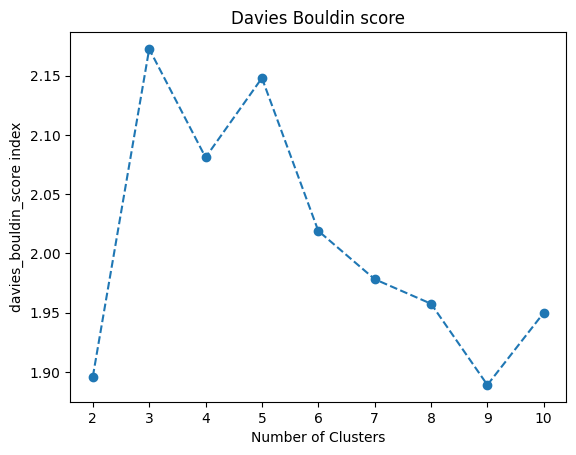

In [152]:
plt.plot(range(2, 11), dbs, marker='o', linestyle='--')
plt.title('Davies Bouldin score')
plt.xlabel('Number of Clusters')
plt.ylabel('davies_bouldin_score index')


Like silhouette coefficient and Calinski-Harabasz index, the DB index captures both the separation and compactness of the clusters. In this graph we are looking for minimal value of score. The Davies Bouldin score is minimized with 2th or 9th clusters and this number can be considered for the k means algorithm.

### Hierarchical clustering

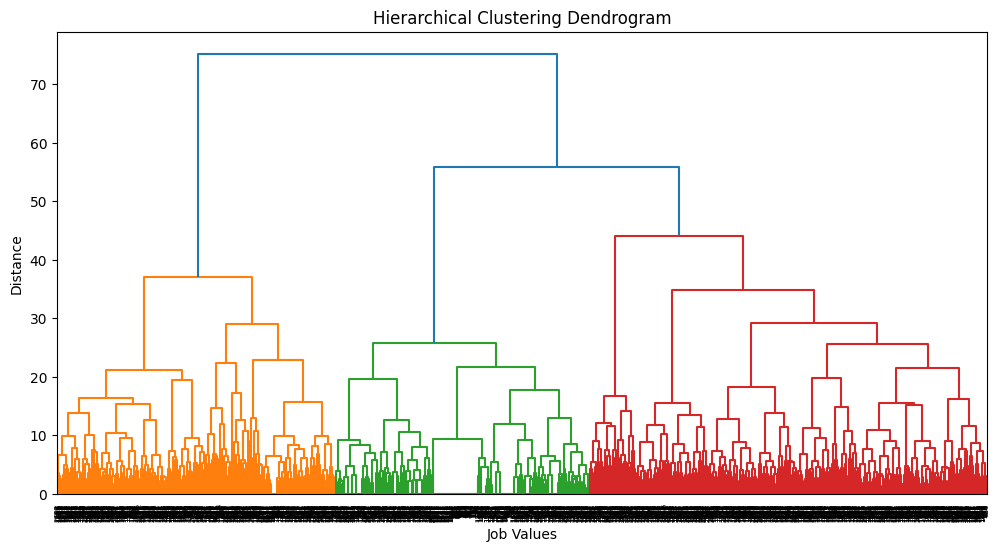

In [153]:
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt

# Perform hierarchical clustering
hierarchical_clusters = linkage(X, method='ward')

# Plot dendrogram
plt.figure(figsize=(12, 6))
dendrogram(hierarchical_clusters, labels=X.index, leaf_rotation=90)
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Job Values")
plt.ylabel("Distance")
plt.show()


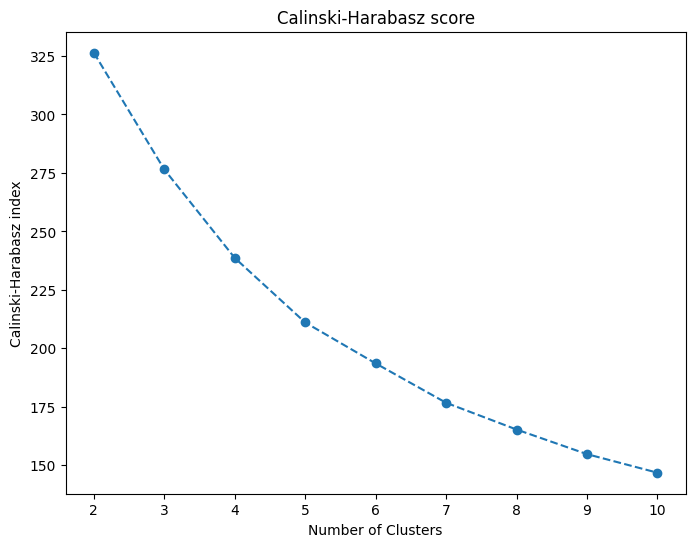

In [154]:
from scipy.cluster.hierarchy import linkage, fcluster

chs = []
dbs=[]
for k in range(2,11):
    labels = fcluster(hierarchical_clusters, k, criterion='maxclust')

    calinski_harabasz = calinski_harabasz_score(X, labels)
    chs.append(calinski_harabasz)
    dbs.append(davies_bouldin_score(X, labels))

plt.figure(figsize=(8, 6))
plt.plot(range(2, 11), chs, marker='o', linestyle='--')
plt.title('Calinski-Harabasz score')
plt.xlabel('Number of Clusters')
plt.ylabel('Calinski-Harabasz index')
plt.show()

Text(0, 0.5, 'davies_bouldin_score index')

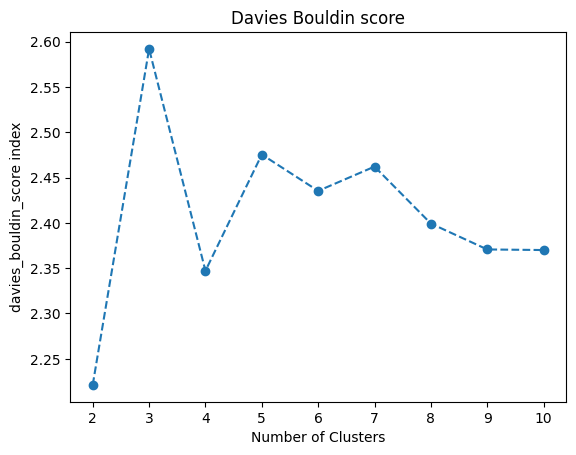

In [155]:
plt.plot(range(2, 11), dbs, marker='o', linestyle='--')
plt.title('Davies Bouldin score')
plt.xlabel('Number of Clusters')
plt.ylabel('davies_bouldin_score index')


The situation looks simmilar to the kmeans results. On the calinski harabasz score plot we cant see any elbow to determine number of clusters. In Davies Bouldin score 2 clusters can be considered.

Calinski harabasz score is slightly lower for hierarchical clustering algorithm. It falls from 325 to 150, while for kmeans it's from 530 to 200. On the other hand Davies Bouldin score is between 1.86 and 2.17 for kmeans and from 2.21 to 2.59 for hierarchical methods. It's hard to determine which one is better. 
Based on davies bouldin index we can say that 2 clusters will be the best. 

In [159]:
kmeans = KMeans(n_clusters=2, init='k-means++', max_iter=300, n_init=10, random_state=42)
kmeans.fit_predict(X)

ch_kmeans = calinski_harabasz_score(X, kmeans.labels_)
db_kmeans = davies_bouldin_score(X, kmeans.labels_)

labels_hier = fcluster(hierarchical_clusters, 2, criterion='maxclust')

ch_hier = calinski_harabasz_score(X, labels_hier)
db_hier = davies_bouldin_score(X, labels_hier)

print(f"kmeans: \ncalinski-harabasz: {ch_kmeans:.2f}, davies_bouldin: {db_kmeans:.2f}\nhierarchical clustering:\ncalinski-harabasz: {ch_hier:.2f}, davies_bouldin: {db_hier:.2f}")


kmeans: 
calinski-harabasz: 527.41, davies_bouldin: 1.90
hierarchical clustering:
calinski-harabasz: 326.41, davies_bouldin: 2.22


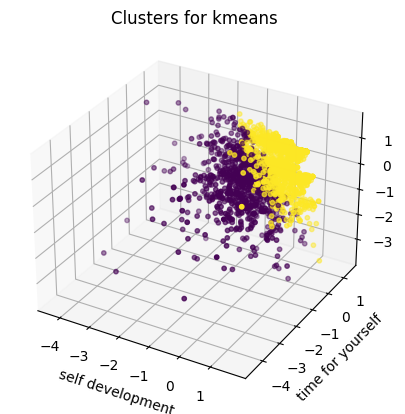

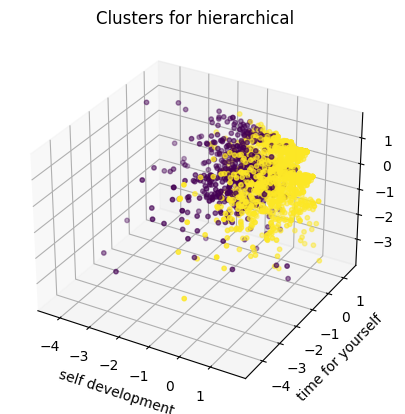

In [160]:
def plot_clusters(cluster_labels, title):
    ax = plt.axes(projection='3d')

    ax.scatter3D(X_transformed[:,0], X_transformed[:,1], X_transformed[:,2], s=10, c=cluster_labels)
    ax.set_xlabel('self development')
    ax.set_ylabel('time for yourself')
    ax.set_zlabel('economic situation')
    ax.set_title(title)

    plt.show()


plot_clusters(kmeans.labels_, 'Clusters for kmeans')
plot_clusters(labels_hier, 'Clusters for hierarchical')

In [163]:
centroids = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_), columns=X.columns)
centroids

,Work_Autonomy,Job_Stability,Opportunity_Things,High_Income,Meeting_Challenges,Good_Prospects,Have_Yourself,Acknowledgment_Acknowledgment,Opportunity_Yourself,Work_Balance
0,3.962138,4.397550,4.258352,3.710468,3.706013,3.933185,4.114699,3.040089,3.585746,4.084633
1,4.477441,4.861362,4.880230,4.446267,4.484003,4.735849,4.771124,3.900738,4.393765,4.819524


In [165]:
centroids.iloc[1, :] - centroids.iloc[0, :]

Work_Autonomy                    0.515302
Job_Stability                    0.463812
Opportunity_Things               0.621878
High_Income                      0.735800
Meeting_Challenges               0.777990
Good_Prospects                   0.802664
Have_Yourself                    0.656425
Acknowledgment_Acknowledgment    0.860649
Opportunity_Yourself             0.808019
Work_Balance                     0.734892
dtype: float64

In [167]:
np.unique(kmeans.labels_, return_counts=True)

(array([0, 1], dtype=int32), array([ 898, 1219]))

Clusters created by kmeans and hierarchical clustering look very different. We've analyzed the centroids of clusters created by kmeans. They are quite simmilar, but in cluster 0 we have lover scores for all categories, especially for acknowledgment, good prospects and opportunities for themselves. There are also less students in cluster 0. We could conclude that one group represent more ambitious students. However, the results aren't very convincing, especially after looking on the plot, but maybe the dimentions used for clustering aren't represented by these after factor analysis.